# 1b. Introduction to Neural Networks

Recommended reading: [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio and Aaron Courville

## Biological Neuron

Inspired by the biological neural network of the brain. Dentrites propagate the electrochemical signal to the cell body of the neuron. It is then decided whether to further transmit a signal to connected neurons via the axon terminal.


<img src="../img/introduction/1920px-Neuron_Hand-tuned.svg.png" width="700" alt="Dentrites">

By Quasar Jarosz at English Wikipedia, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=7616130

## Artificial Neuron

### Perceptron

The perceptron was invented in 1958 by Frank Rosenblatt along with a training algorithm.

<img src="../img/introduction/Rosenblatt_21.jpg" width="200" alt="Frank Rosenblatt">

By Anonymous at English Wikipedia, CC BY-SA 4.0, https://commons.wikimedia.org/wiki/File:Rosenblatt_21.jpg

Binary classifier function:

$ f(x) = \begin{cases} 1 & \text{if } w_1x_1 + w_2x_2 + ... + w_nx_n > b\\ 0 & \text{otherwise} \end{cases} $

The bias can also be represented as a weight. When we define a feature $ x_0 $ to be 1, then the first weight $ w_0 $ is a constant.

Algorithm:

Let $ y_{pred} $ be the prediction and $ y_{true} $ be the desired output (label). The magnitude of updates is controlled by the learning rate $ r $.

1. Initialize weights to 0 or small random value
2. Calculate the predicted output $ y_{pred} = f(w*x) $
3. Update weights $ w_i(t+1) = w_i(t) + r*(y_{true} - y_{pred}(t))*x_i $

Caveats:
* Works only for single-layer perceptrons, not for multi-layer perceptrons
* Convergence only guaranteed for linear separable problems

### Linear separability

<img src="../img/introduction/Linearly_separable_red-blue_cropped_.svg" width="200" alt="Linear Separability">

By Krb19 at English Wikipedia, CC BY-SA 4.0, https://commons.wikimedia.org/wiki/File:Linearly_separable_red-blue_cropped_.svg


## Neural Network

What we want:
* Approximation of any continuous function on a compact subset
* Easy training algorithm
* Converging into the global optimum for convex problems, finding good local minima for non-convex problems

### Universal approximation theorem

A neural network with only one hidden layer can approximate any continuous function on a compact subset.

Instead of a threshold function we use the sigmoid.

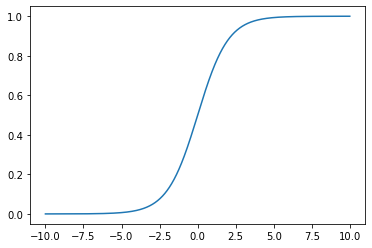

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np


def sigmoid(x):
    return 1/(1+np.exp(-x))


def plot_fn(fn, low, high, step=0.01):
    xs = [x for x in np.arange(low, high, step)]
    ys = list(map(fn, xs))
    return plt.plot(xs, ys)


plot_fn(sigmoid, -10, 10)

1. Derivative of sigmoid easy to compute $ \sigma(x)` = \sigma(x)*(1-\sigma(x)) $, paper and pencil solution, see e.g. https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
2. Sigmoid can be made nearly identical to step function

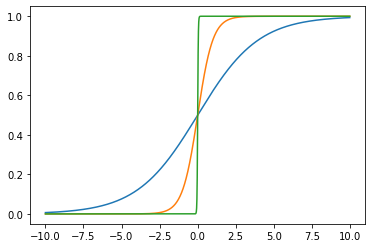

In [3]:
def like_step_function(w, b):
    return lambda x: sigmoid(w*x + b)


plot_fn(like_step_function(0.5, 0), -10, 10)
plot_fn(like_step_function(2, 0), -10, 10)
plot_fn(like_step_function(50, 0), -10, 10)

3. Step can be shifted

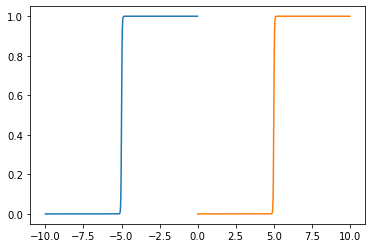

In [4]:
def shifted_step(shift, w=50):
    b = -shift*w
    return lambda x: sigmoid(w*x + b)


plot_fn(shifted_step(-5), -10, 0)
plot_fn(shifted_step(5), 0, 10)

4. Step can be scaled when passing result into output neuron with identity activation (no activation)

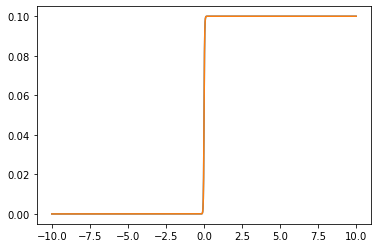

In [5]:
def scaled_step(height):
    w = height
    b = 0
    
    hidden = lambda x: sigmoid(50*x)
    return lambda x: w*hidden(x) + b


plot_fn(scaled_step(0.1), -10, 10)
plot_fn(scaled_step(0.1), -10, 10)

5. Shift and scale can be combined

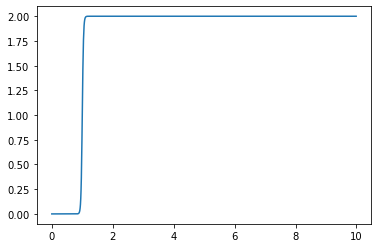

In [6]:
def scaled_shifted_step(height, shift):
    hidden = shifted_step(shift)
    return lambda x: height*hidden(x)


plot_fn(scaled_shifted_step(2, 1), 0, 10)

5. Steps can be combined to build plateaus when using matrix multiplication

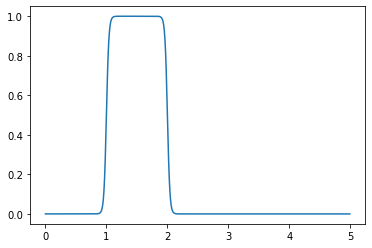

In [7]:
def scaled_shifted_steps(heights, shifts):
    hidden = shifted_step(shifts)
    return lambda x: np.matmul(heights, hidden(x))


def combined_steps(heights, shifts):
    heights = np.array(heights)
    shifts = np.array(shifts)
    
    return scaled_shifted_steps(heights, shifts)
    
plot_fn(combined_steps([1, -1], [1, 2]), 0, 5)

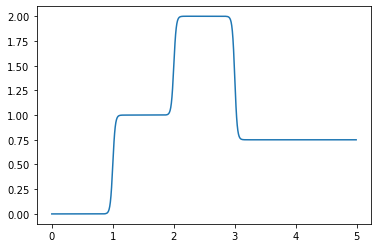

In [12]:
plot_fn(combined_steps([1, -1, 2, -2, 0.75], [1, 2, 2, 3, 3]), 0, 5)

The plateaus can be combined to approximate any continuous function on a compact subset. More neurons in the hidden layer make the approximation more fine-grained.

### Multi-layer perceptron

Has at least one hidden layer, all layers are fully connected. 

As a rule of thumb deeper with fewer neurons in each layer are computationally more efficient than shallow networks with more neurons in each layer. Very deep networks need techniques like skip connections to keep the optimization landscape less chaotic.

The number of neurons in the layer greatly affects the number of multiply-add operations in the network and has a huge impact on computational resources required.

In [253]:
def random_uniform_with_max(max_value):
    return lambda inputs, num_outputs: np.random.rand(inputs, num_outputs) * max_value

def layer(inputs, num_neurons, initializer=random_uniform_with_max(0.1), activation=sigmoid):
    inputs = np.array(inputs)
    weights = initializer(inputs.shape[-1], num_neurons)
    return activation(np.matmul(inputs, weights))


# inputs
instance1 = [1, 2, 3]
instance2 = [2, 5, 4]
batch = [instance1, instance2]

# network with 2 hidden layers
fc1 = layer(batch, 64)
fc2 = layer(fc1, 32)
out = layer(fc2, 5)

print(out)

[[0.79170478 0.80371821 0.83354453 0.83486363 0.75352825]
 [0.79680034 0.80893399 0.83871318 0.8400169  0.75832222]]


## Training

Neural networks consist of differentiable operations. The common training method nowadays is gradient descent. The learning rate influences the step size into the downward direction. When the learning rate is too high, you may overshoot the minimum. When the learning rate is too low, training will take very long. Libraries like fast.ai offer a learning rate finder for a good learning rate to start with.

<img src="../img/introduction/LearningRateTooLarge.svg" width=700 alt="Learning Rate">

Image by Google at https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate

Convex problems like the logistic regression always converge into the global minimum. For non-convex problems the algorithm may find a local minimum which is hopefully good enough.

<img src="../img/introduction/Non-Convex_Objective_Function.gif" width="700" alt="Optimization Landscape">

By Zachary kaplan at English Wikipedia, CC BY-SA 4.0, https://commons.wikimedia.org/wiki/File:Non-Convex_Objective_Function.gif

Learn more about gradient descent at [Intro to optimization in deep learning: Gradient Descent](https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/).

Loss landscapes for various network architectures:

<img src="../img/introduction/loss_landscapes.png" width="700" alt="Loss Landscapes">

From [Visualizing the Loss Landscape of Neural Nets](https://www.cs.umd.edu/~tomg/projects/landscapes/)

For more info about advanced training methods, see e.g. [Snapshot Ensembles](https://arxiv.org/abs/1704.00109):

<img src="../img/introduction/snapshot_ensemble.png" width="700" alt="Snapshot Ensemble">

## Initialization and Activation

Initialization of weights needs to be chosen according to the activation function.

When using the sigmoid function, large positive or negative weights are bad because the function saturates on both ends and the derivative will be near zero which in turn hinders backpropagation. Remember that the chain rule is applied for nested functions and multiplying small values with small values results in even smaller ones. You also have to consider the number of inputs in weight scaling because all of the inputs are multiplied by the weights and added up before they are passed into the sigmoid.

As artificial neural networks were inspired by biology, sigmoid as a thresholding mechanism seemed like a natural choice. But saturation on both ends actually makes it perform badly in the backpropagation phase.

ReLU (rectified linear units) solve this problem by activating linearly on the positive side. But because they activate to 0 on the negative side, the network can suffer from the dying ReLU problem when all neurons output 0 which also kills the back propagation signal. But computation is verfy efficient, even on mobile devices.

To solve the problem of dying ReLUs, variants like the Leaky ReLU, PReLu, ELU, SELU have been introduced. They have a small slope on the negative side and so signal back propagation can recover.

Which initialization method works well with which activation function is normally described in academic papers. Some common settings are described in Hands-On Machine Learning with Scikit-Learn and TensorFlow, 2nd edition, p. 328, table 11-1:

| Initialization | Activation | 
| --- | --- | 
| Xavier Glorot | none, tanh, sigmoid, softmax |
| He | ReLU & variants |
| LeCun | SELU |

Find out more about activation functions at https://mlfromscratch.com/activation-functions-explained/.

### Plots of Activation Functions

The functions are documented at https://pytorch.org/docs/stable/nn.functional.html.

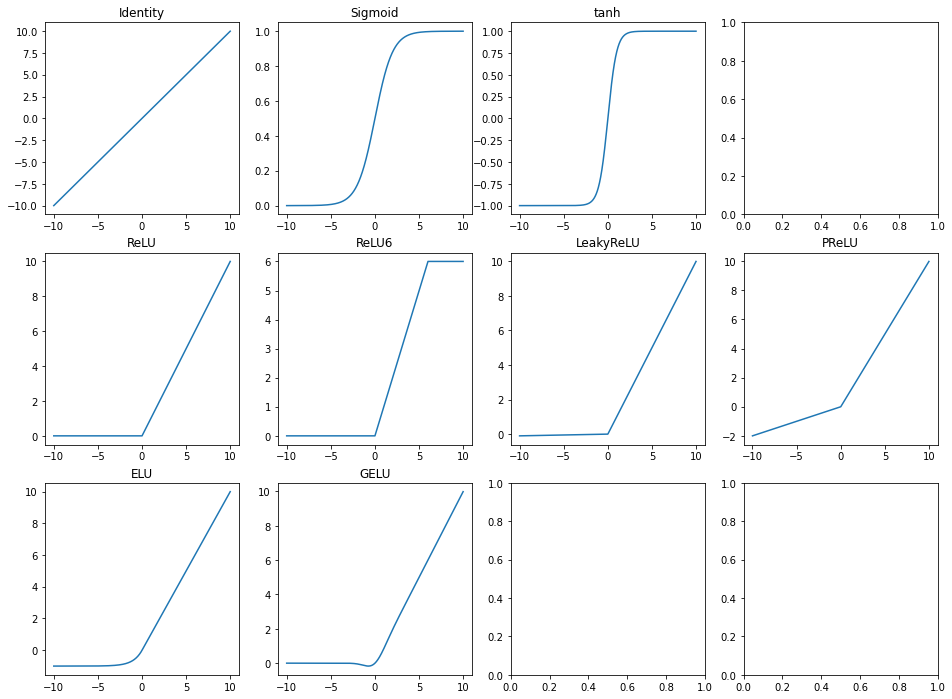

In [304]:
from torch.nn.functional import relu, relu6, leaky_relu, tanh, prelu, elu, gelu
from torch.nn import Identity
from torch import tensor, sigmoid


def plot_torch_fn(fn, low, high, step=0.01, plot=None, title=None):
    xs = [tensor(x) for x in np.arange(low, high, step)]
    ys = list(map(fn, xs))
    
    plot = plt if plot is None else plot
    if title is not None:
        plot.title.set_text(title)

    return plot.plot(xs, ys)


plt.rcParams['figure.figsize'] = [16, 12]
fig, axs = plt.subplots(nrows=3, ncols=4)

plot_torch_fn(Identity(), -10, 10, plot=axs[0, 0], title="Identity")
plot_torch_fn(sigmoid, -10, 10, plot=axs[0, 1], title="Sigmoid")
plot_torch_fn(tanh, -10, 10, plot=axs[0, 2], title="tanh")

plot_torch_fn(relu, -10, 10, plot=axs[1, 0], title="ReLU")
plot_torch_fn(relu6, -10, 10, plot=axs[1, 1], title="ReLU6")
plot_torch_fn(leaky_relu, -10, 10, plot=axs[1, 2], title="LeakyReLU")
plot_torch_fn(lambda x: prelu(x, weight=tensor(0.2)), -10, 10, plot=axs[1, 3], title="PReLU")

plot_torch_fn(elu, -10, 10, plot=axs[2, 0], title="ELU")
plot_torch_fn(gelu, -10, 10, plot=axs[2, 1], title="GELU")